# LSTM 

Resources: 

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://medium.com/analytics-vidhya/beginners-guide-to-stock-prediction-using-lstm-7010bf8b8c21

https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

https://github.com/MohammadFneish7/Keras_LSTM_Diagram


## Imports

In [9]:
!pip install cartopy
!pip install mpl_scatter_density
!pip uninstall shapely
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: shapely 2.0.0
Uninstalling shapely-2.0.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/shapely-2.0.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/shapely.libs/libgeos-ee7a1634.so.3.11.1
    /usr/local/lib/python3.8/dist-packages/shapely.libs/libgeos_c-5ef8a841.so.1.17.1
    /usr/local/lib/python3.8/dist-packages/shapely/*
Proceed (y/n)? y
  Successfully uninstalled shapely-2.0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 20

In [1]:
import os
import time
import pandas as pd
import numpy as np
from scipy.io import loadmat
from google.colab import drive
import pickle
import shapely
import random

import cartopy #Was throwing an error, couldn't tell you why?
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import cartopy.mpl.geoaxes

import mpl_scatter_density # adds projection='scatter_density'
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.io import loadmat

import sklearn.metrics as skm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow import keras

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def latlon_setup(df, n_input):
    pixel_counts = df.groupby(['lat', 'lon']).size() #Counts
    pixel_counts = pixel_counts.reset_index()
    #Remove lat/lon sets that don't have enough records, as defined by our n_input variable
    latlon = pd.lreshape(pixel_counts[pixel_counts[0] > (n_input -1)][['lat', 'lon']], {'lat':['lat'], 'lon':['lon']})
    latlon = latlon.drop_duplicates()
    #Make sure that we aren't sampling in a pattern:
    latlon = latlon.sample(frac = 1, random_state = 0)
    print("Length of df of unique latlon paris that meet cutoff: ", len(latlon)) #if 60: 123873, if 80: 85603
    return latlon

In [ ]:
def gen_np(df, n_input):
  """Produces sequential windows of n_input historical records of data from the provided dataframe."""
  num_windows = len(df) - n_input + 1
  # make slices of data
  Xs, ys = [], []

  for w in range(num_windows):
      current_slice = df.iloc[w:w+n_input]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h']].values
      y = current_slice[['density', 'voc']].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

In [ ]:
def rand_gen_np(df, n_input):
  """Returns random windows of input data at 1/10th rate """
  all_windows = list(range(len(df) - n_input + 1)) #List of total number of records in the dataframe minus the n_input window size
  n_samples = int(((len(df) - n_input + 1)/10) + 1) #all windows large enough not to be weeded out get at least one sample
  # make slices of data
  Xs, ys = [], []

  for w in range(n_samples): #For every sample we want to take:
      window = random.choice(all_windows) #Randomly select which window to take
      all_windows.remove(window) #Remove selection from list to prevent resampling
      current_slice = df.iloc[window:window+n_input]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h']].values
      y = current_slice[['density', 'voc']].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

In [ ]:
def data_prep_gen(bigdf, latlon, path, n_input, n_features, X, y, counter = 0, savept = 0):
    start = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    for i in range(len(latlon)-counter): #Iterate though our set of viable lat/lons, minus counter to restart if needed.
      counter += 1
      df = bigdf[(bigdf['lat'] == latlon['lat'].iloc[i]) & (bigdf['lon'] == latlon['lon'].iloc[i])] #Make a sub df of each lat/lon pair
      df = df.sort_values(by = 'date') #Make sure we have our values correctly ordered
      X2, y2 = rand_gen_np(df, n_input) #Make your arrays, in this case random
      #print("Dimensions: ", X2.shape, y2.shape)
      X = np.vstack([X, X2]) #Append your arrays
      y = np.concatenate([y, y2])
      if counter%1000 == 0: #For every ten thousand lat/long pairs acts as check point
        print("Counter: ", counter, ", Shape X: ", X.shape, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        with open((path + str(savept) + '.npy'), 'wb') as f: #Saves two arrays in same file, arrays can be opened separately.
          np.save(f, X)
          np.save(f, y)
        print("Wipeout: ", savept)
        savept += 1
        X = np.empty([0, n_input, n_features])
        y = np.empty([0,2])
    print("Save last: ")
    with open((path + '_last.npy'), 'wb') as f: #final save of X,y to grab any remaining lat/lon pairs since last checkpoint:
          np.save(f, X)
          np.save(f, y)
    print("Done! And it only took from ", start, " to ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

In [ ]:
def data_prep_rand_gen(bigdf, latlon, path, n_input, n_features, X , y, counter = 0, savept = 0):
    start = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print("Starting at: ", start)
    for i in range(len(latlon)-counter): #Iterate though our set of viable lat/lons, minus counter to restart if needed.
      counter += 1
      df = bigdf[(bigdf['lat'] == latlon['lat'].iloc[i]) & (bigdf['lon'] == latlon['lon'].iloc[i])] #Make a sub df of each lat/lon pair
      df = df.sort_values(by = 'date') #Make sure we have our values correctly ordered
      X2, y2 = rand_gen_np(df, n_input) #Make your arrays, in this case random
      #print("Dimensions: ", X2.shape, y2.shape)
      X = np.vstack([X, X2]) #Append your arrays
      y = np.concatenate([y, y2])
      if counter%10000 == 0: #For every ten thousand lat/long pairs acts as check point
        print("Counter: ", counter, ", Shape X: ", X.shape, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        with open((path + str(savept) + '.npy'), 'wb') as f: #Saves two arrays in same file, arrays can be opened separately.
          np.save(f, X)
          np.save(f, y)
        print("Wipeout: ", savept)
        savept += 1
        X = np.empty([0, n_input, n_features])
        y = np.empty([0,2])
    print("Save last: ")
    with open((path + '_last.npy'), 'wb') as f: #final save of X,y to grab any remaining lat/lon pairs since last checkpoint:
          np.save(f, X)
          np.save(f, y)
    print("Done! And it only took from ", start, " to ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

## Data Prep Example

In [ ]:
# #DataPrep: Scaling
# data = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/processed_data_with_datetime.parquet')
# scaler = MinMaxScaler() 
# data_scaled = data[['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']] #We want lat, lon and date unscaled, as these will be used for sorting, not training. 
# data_scaled = pd.DataFrame(scaler.fit_transform(data_scaled), columns=data_scaled.columns)
# data_scaled['lat'] = data['lat']
# data_scaled['lon'] = data['lon']
# data_scaled['date'] = data['date']
# display(data_scaled.head())
# data_scaled.to_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/scaled_processed_data_LatLonDateUnscaled.parquet')
# del(data)
# # Test/Train split:
# train_scaled = data_scaled[data_scaled['date']<'2020-01-01']
# display(train_scaled.tail())
# train_scaled.to_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/train_scaled_LatLonDateUnscaled.parquet')
# del(train_scaled)
# test_scaled = data_scaled[data_scaled['date']>='2020-01-01']
# display(test_scaled.head())
# test_scaled.to_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/test_scaled_LatLonDateUnscaled.parquet')
# del(test_scaled)
# del(data_scaled)

In [ ]:
# Import data:
train = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/train_scaled_LatLonDateUnscaled.parquet')

print(train.columns)

print(train['date'].max())
print(train['date'].min())
print(len(train))
print(train.info())
train.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2019-12-31 00:00:00
2019-01-01 00:00:00
18329587
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18329587 entries, 0 to 18329586
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.8 GB
None


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
0,0.166630,0.908916,0.998302,0.779338,0.710750,0.708752,0.305672,0.124832,0.240164,62.684110,-160.44087,2019-01-01
1,0.176869,0.955726,0.995804,0.783470,0.715650,0.708749,0.311526,0.123756,0.228918,62.532246,-160.44087,2019-01-01
2,0.180525,0.959748,0.996218,0.790908,0.722035,0.714708,0.322348,0.123569,0.242246,62.381150,-160.44087,2019-01-01
3,0.183057,0.966050,0.996963,0.790081,0.721543,0.716810,0.302173,0.123513,0.240669,62.230810,-160.44087,2019-01-01
4,0.167732,0.926476,0.995828,0.789999,0.709735,0.705815,0.303099,0.123518,0.239886,62.684110,-160.34750,2019-01-01


Whatever we pick as n_input (number of historical records) will be our cutoff value - any pixels that have fewer than n_input records can not be run. 

If we were to set n_input to three, we would go from 467957 pixels to 428025. A minimal loss. 

Similar to this problem: 
https://stackoverflow.com/questions/61177311/creating-a-timeseriesgenerator-with-multiple-inputs

In [ ]:
n_input = 3 #how many samples/rows/timesteps to look in the past in order to forecast the next sample

pixel_counts = train.groupby(['lat', 'lon']).size()
pixel_counts = pixel_counts.reset_index()
print(pixel_counts.head())

#There are 467957 pixel locations in our set. Get all unique pairs of lat lon:

display(pixel_counts[pixel_counts[0] > n_input])
print(len(pixel_counts[pixel_counts[0] > n_input]))

latlon = pd.lreshape(pixel_counts[pixel_counts[0] > n_input][['lat', 'lon']], {'lat':['lat'], 'lon':['lon']})

latlon = latlon.drop_duplicates()
print(len(latlon))
latlon.head()

         lat        lon  0
0 -54.977610 -67.920130  1
1 -54.855858 -67.826770  3
2 -54.855858 -67.733406  2
3 -54.855858 -67.546684  2
4 -54.855858 -67.453316  1


,lat,lon,0
10,-54.73447,-68.106850,5
11,-54.73447,-68.013490,5
12,-54.73447,-67.826770,5
13,-54.73447,-67.733406,4
15,-54.73447,-67.546684,4
...,...,...,...
467952,81.24827,-19.559128,5
467953,81.24827,-19.465767,5
467954,81.24827,-19.372406,5
467955,81.24827,-19.279045,5


413624
413624


,lat,lon
0,-54.73447,-68.106850
1,-54.73447,-68.013490
2,-54.73447,-67.826770
3,-54.73447,-67.733406
4,-54.73447,-67.546684


In [ ]:
#Try getting all values for a specific lat/lon pair:
train1 = train[(train['lat'] == latlon['lat'].iloc[0]) & (train['lon'] == latlon['lon'].iloc[0])]
print(len(train1))
print(train1['date'].min())
print(train1['date'].max())
display(train1.head())
#Looks good. 

#Get all values for a second lat/lon pair:
train2 = train[(train['lat'] == latlon['lat'].iloc[1]) & (train['lon'] == latlon['lon'].iloc[1])]
print(len(train2))
print(train2['date'].min())
print(train2['date'].max())
display(train2.head())

5
2019-08-11 00:00:00
2019-08-19 00:00:00


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
13562138,0.412166,0.816258,0.998811,0.7,0.668379,0.677059,0.319354,0.133275,0.703391,-54.73447,-68.10685,2019-08-11
13563663,0.417339,0.805035,0.996234,0.7,0.678995,0.684643,0.319354,0.133275,0.703552,-54.73447,-68.10685,2019-08-12
13565561,0.428953,0.870483,0.999304,0.7,0.677228,0.677272,0.319354,0.133275,0.703702,-54.73447,-68.10685,2019-08-14
13566803,0.436613,0.892357,0.993725,0.7,0.677911,0.682764,0.319354,0.133275,0.703682,-54.73447,-68.10685,2019-08-15
13568994,0.461971,0.903925,0.998780,0.7,0.672902,0.674774,0.319354,0.133275,0.703603,-54.73447,-68.10685,2019-08-19


5
2019-08-11 00:00:00
2019-08-19 00:00:00


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
13562142,0.412067,0.817112,0.995011,0.7,0.668841,0.675598,0.321291,0.130967,0.703391,-54.73447,-68.01349,2019-08-11
13563678,0.416563,0.807155,0.992390,0.7,0.677074,0.683424,0.321291,0.130967,0.703552,-54.73447,-68.01349,2019-08-12
13565563,0.426910,0.870855,0.998475,0.7,0.673722,0.678564,0.321291,0.130967,0.703702,-54.73447,-68.01349,2019-08-14
13566807,0.433939,0.892694,0.990807,0.7,0.677054,0.680754,0.321291,0.130967,0.703682,-54.73447,-68.01349,2019-08-15
13569000,0.457130,0.910077,0.997865,0.7,0.671337,0.676375,0.321291,0.130967,0.703603,-54.73447,-68.01349,2019-08-19


In [ ]:
# #To illistrate how Generators works include a reset index:
# train1 = train1.reset_index(drop = True)
# train1 = train1.reset_index()
# print(train1.head())

# train2 = train2.reset_index(drop = True)
# train2 = train2.reset_index()
# train2.head()

   index   density  snowtemp  soiltemp     omega       Tbh       Tbv  \
0      0  0.166630  0.908916  0.998302  0.779338  0.710750  0.708752   
1      1  0.203359  0.553834  0.998184  0.779338  0.714580  0.707774   
2      2  0.191918  0.581473  0.992350  0.779338  0.713668  0.711221   
3      3  0.194654  0.425676  0.988548  0.779338  0.711498  0.705567   
4      4  0.196457  0.282219  0.980238  0.779338  0.714373  0.709466   

         cf         h       voc       lat        lon       date  
0  0.305672  0.124832  0.240164  62.68411 -160.44087 2019-01-01  
1  0.305672  0.124832  0.240019  62.68411 -160.44087 2019-01-08  
2  0.305672  0.124832  0.240003  62.68411 -160.44087 2019-01-09  
3  0.305672  0.124832  0.239988  62.68411 -160.44087 2019-01-10  
4  0.305672  0.124832  0.239974  62.68411 -160.44087 2019-01-11  


,index,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
0,0,0.176869,0.955726,0.995804,0.78347,0.715650,0.708749,0.311526,0.123756,0.228918,62.532246,-160.44087,2019-01-01
1,1,0.200845,0.564406,0.994576,0.78347,0.718182,0.716408,0.311526,0.123756,0.228975,62.532246,-160.44087,2019-01-08
2,2,0.188242,0.584642,0.988450,0.78347,0.710517,0.714051,0.311526,0.123756,0.228984,62.532246,-160.44087,2019-01-09
3,3,0.190667,0.460968,0.984354,0.78347,0.714821,0.706018,0.311526,0.123756,0.228993,62.532246,-160.44087,2019-01-10
4,4,0.192554,0.298409,0.975456,0.78347,0.714592,0.709420,0.311526,0.123756,0.229001,62.532246,-160.44087,2019-01-11


In [ ]:
#Lets try reshaping as a tensor - LSTM takes in a 3d df:  number of samples (row count - n_input) by number of timesteps (rows) by the number of features (columns)
# 41 time steps, 8 features (9 after removing y, lat, lon and date but adding index). sample number depends on n_input size (# of records used to make a prediction)

x_train1 = train1[['index','snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']] #Swap comment if you are using index 
#x_train1 = train1[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']]
x_train1 = np.array(x_train1)
y_train1 = train1[['density']]
y_train1 = np.array(y_train1)
y_train1 = y_train1.reshape(-1) #now is values in one array, not an array of arrays size 1. 

print("set 1:")
print(x_train1.shape)
print(y_train1.shape)

#Second set
x_train2 = train2[['index','snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']]
#x_train2 = train2[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']]
x_train2 = np.array(x_train2)
y_train2 = train2[['density']]
y_train2 = np.array(y_train2)
y_train2 = y_train2.reshape(-1) #now is values in one array, not an array of arrays size 1. 

print("set 2:")
print(x_train2.shape)
print(y_train2.shape)

display(train1.head())
print(y_train1[:5])

set 1:
(41, 9)
(41,)
set 2:
(46, 9)
(46,)


Important note on processing: We are trying to predict the *current* density from our input variables, so there is no need to move our y_data one forward. 

In [ ]:
#https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

n_features= x_train1.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 50 # Number of timeseries samples in each batch. It will self limit to feasable size, so you can go over and it will self correct with no error

generator = TimeseriesGenerator(x_train1, y_train1, length=n_input, batch_size=b_size)
generator2 = TimeseriesGenerator(x_train2, y_train2, length=n_input, batch_size=b_size)

print("shape generator 1:", generator[0][0].shape)
print("shape generator 1:", generator2[0][0].shape)

print("generator 1 content:")
generator[0][0]

shape generator 1: (38, 3, 9)
shape generator 1: (43, 3, 9)
generator 1 content:


array([[[ 0.        ,  0.90891553,  0.99830206, ...,  0.3056722 ,
          0.12483246,  0.24016423],
        [ 1.        ,  0.55383357,  0.99818396, ...,  0.3056722 ,
          0.12483246,  0.24001892],
        [ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276]],

       [[ 1.        ,  0.55383357,  0.99818396, ...,  0.3056722 ,
          0.12483246,  0.24001892],
        [ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276],
        [ 3.        ,  0.42567649,  0.98854799, ...,  0.3056722 ,
          0.12483246,  0.23998776]],

       [[ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276],
        [ 3.        ,  0.42567649,  0.98854799, ...,  0.3056722 ,
          0.12483246,  0.23998776],
        [ 4.        ,  0.28221916,  0.98023832, ...,  0.3056722 ,
          0.12483246,  0.23997391]],

       ...,

       [[35.        ,  0.35802195,  0.96498329, ...,  0.3056722

In [ ]:
generator.targets #Generator targets is just a stright reproduction of y_train

array([0.16662979, 0.20335938, 0.19191794, 0.19465384, 0.196457  ,
       0.19744315, 0.18722819, 0.17017889, 0.20717552, 0.21762509,
       0.24080997, 0.22371299, 0.22260159, 0.1603912 , 0.16048403,
       0.16058131, 0.15255736, 0.10457073, 0.14727694, 0.15503449,
       0.15932876, 0.17938672, 0.19660069, 0.17692231, 0.16101366,
       0.15264193, 0.14955569, 0.12343908, 0.14789623, 0.18848583,
       0.30205393, 0.28712824, 0.27823069, 0.27691329, 0.27262028,
       0.2756086 , 0.27673971, 0.27772458, 0.27585466, 0.25279503,
       0.24062114])

In [ ]:
#Lets try appending these generator objects:

#We can use the generator object to build out our moving windows along each set,
# then concatinate the arrays inside of it into one large dataset for training. 
gen = np.vstack([generator[0][0], generator2[0][0]])
ygen_noprocess = np.concatenate([generator.targets, generator2.targets])
ygen = np.concatenate([generator.targets[1:-(n_input-1)], generator2.targets[1:-(n_input-1)]])

print(len(ygen_noprocess)) #This one is six longer, since there was an overhang of 3 extra values for each generator object. 
print(len(ygen))

print(gen.shape)
gen

87
81
(81, 3, 9)


array([[[ 0.        ,  0.90891553,  0.99830206, ...,  0.3056722 ,
          0.12483246,  0.24016423],
        [ 1.        ,  0.55383357,  0.99818396, ...,  0.3056722 ,
          0.12483246,  0.24001892],
        [ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276]],

       [[ 1.        ,  0.55383357,  0.99818396, ...,  0.3056722 ,
          0.12483246,  0.24001892],
        [ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276],
        [ 3.        ,  0.42567649,  0.98854799, ...,  0.3056722 ,
          0.12483246,  0.23998776]],

       [[ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276],
        [ 3.        ,  0.42567649,  0.98854799, ...,  0.3056722 ,
          0.12483246,  0.23998776],
        [ 4.        ,  0.28221916,  0.98023832, ...,  0.3056722 ,
          0.12483246,  0.23997391]],

       ...,

       [[40.        ,  0.41487661,  0.95611865, ...,  0.3115256

In [ ]:
#What about using only numpy to pre-process?
# https://stackoverflow.com/questions/66353849/confusions-about-the-input-shape-in-lstm-models

n_features= 8 # how many predictors/Xs/features we have to predict y

def gen_np(df, window):
  num_windows = len(df) - window + 1
  # make slices of data
  Xs, ys = [], []

  for w in range(num_windows):
      current_slice = df.iloc[w:w+window]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']].values
      y = current_slice['density'].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

X, y = gen_np(train1, n_input)

# check the shape
print(X.shape)
print(y.shape)
display(train1.head()) #for refference
print(X[:5])
print(y)

(3, 3, 8)
(3,)


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
13562138,0.412166,0.816258,0.998811,0.7,0.668379,0.677059,0.319354,0.133275,0.703391,-54.73447,-68.10685,2019-08-11
13563663,0.417339,0.805035,0.996234,0.7,0.678995,0.684643,0.319354,0.133275,0.703552,-54.73447,-68.10685,2019-08-12
13565561,0.428953,0.870483,0.999304,0.7,0.677228,0.677272,0.319354,0.133275,0.703702,-54.73447,-68.10685,2019-08-14
13566803,0.436613,0.892357,0.993725,0.7,0.677911,0.682764,0.319354,0.133275,0.703682,-54.73447,-68.10685,2019-08-15
13568994,0.461971,0.903925,0.998780,0.7,0.672902,0.674774,0.319354,0.133275,0.703603,-54.73447,-68.10685,2019-08-19


[[[0.81625822 0.99881078 0.69999972 0.66837909 0.67705922 0.3193543
   0.13327522 0.70339097]
  [0.80503465 0.99623414 0.69999972 0.67899542 0.68464269 0.3193543
   0.13327522 0.70355208]
  [0.87048334 0.99930381 0.69999972 0.67722763 0.67727244 0.3193543
   0.13327522 0.7037019 ]]

 [[0.80503465 0.99623414 0.69999972 0.67899542 0.68464269 0.3193543
   0.13327522 0.70355208]
  [0.87048334 0.99930381 0.69999972 0.67722763 0.67727244 0.3193543
   0.13327522 0.7037019 ]
  [0.89235672 0.99372522 0.69999972 0.6779113  0.68276368 0.3193543
   0.13327522 0.70368185]]

 [[0.87048334 0.99930381 0.69999972 0.67722763 0.67727244 0.3193543
   0.13327522 0.7037019 ]
  [0.89235672 0.99372522 0.69999972 0.6779113  0.68276368 0.3193543
   0.13327522 0.70368185]
  [0.90392522 0.99878022 0.69999972 0.67290206 0.67477389 0.3193543
   0.13327522 0.70360281]]]
[0.4289531  0.43661336 0.46197081]


In [ ]:
#Try appending np values: 
X2, y2 = gen_np(train2, n_input)
print("train2:")
print(X2.shape)
print(y2.shape)
X = np.vstack([X, X2])
y = np.concatenate([y, y2])
print("joined 1 and 2:")
print(X.shape)
print(y.shape)

train2:
(3, 3, 8)
(3,)
joined 1 and 2:
(6, 3, 8)
(6,)


## Example model set up and test

In [ ]:
#Initialize:
def model_lstm(lrn_rate = 0.01, mntum = 0):#These variables do nothing??? Why even have them???
  model = keras.models.Sequential()
  #1st layer:
  model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
  model.add(keras.layers.Dropout(0.2))
  #2nd layer:
  model.add(keras.layers.LSTM(50))
  model.add(keras.layers.Dropout(0.2))
  #Output layer:
  model.add(keras.layers.Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  #model.summary()
  return(model)

In [ ]:
model = model_lstm(lrn_rate = 0.01, mntum = 0)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 50)             12000     
                                                                 
 dropout_4 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#modelfit = model.fit(x = generator[0][0], y=generator.targets[1:-(n_input-1)], epochs = 5) #works!
#modelfit = model.fit(x = gen, y=ygen, epochs = 5) #Works!
modelfit = model.fit(x = X, y = y, epochs = 5) #works

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.2085
Epoch 2/5
1/1 [==============================] - 0s 16ms/step - loss: 0.1824
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1728
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1551
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1408


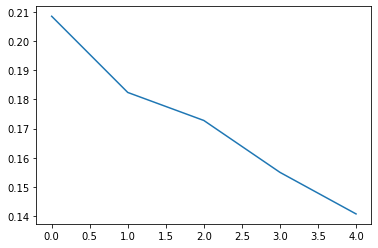

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Example test set prep


In [ ]:
test = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/test_scaled_LatLonDateUnscaled.parquet')

print(test.columns)

print(test['date'].max())
print(test['date'].min())
print(len(test))
print(test.info())
test.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2020-11-20 00:00:00
2020-01-01 00:00:00
13371200
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13371200 entries, 18329587 to 31700786
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.3 GB
None


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
18329587,0.227062,0.605666,0.979289,0.725619,0.710505,0.715126,0.305186,0.113270,0.091060,62.230810,-162.77490,2020-01-01
18329588,0.219363,0.608976,0.971580,0.746666,0.701298,0.703409,0.334429,0.104657,0.247554,62.081207,-162.77490,2020-01-01
18329589,0.232323,0.594961,0.918358,0.745378,0.709829,0.718960,0.299206,0.105855,0.791739,62.230810,-162.49481,2020-01-01
18329590,0.238541,0.589092,0.946560,0.737288,0.713899,0.722697,0.275514,0.112478,0.244870,62.381150,-162.40146,2020-01-01
18329591,0.234994,0.567396,0.862735,0.745613,0.695790,0.703448,0.363539,0.096604,0.162298,61.932335,-162.21474,2020-01-01


In [ ]:
test1 = test[(test['lat'] == latlon['lat'].iloc[0]) & (test['lon'] == latlon['lon'].iloc[0])]
print(len(test1))
print(test1['date'].min())
print(test1['date'].max())
test1.head()
#Testing with the same lat/lon as train, this won't be matched in the larger set.

72
2020-01-01 00:00:00
2020-11-20 00:00:00


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
18329763,0.233223,0.537159,0.959042,0.779338,0.707065,0.712970,0.305672,0.124832,0.234089,62.68411,-160.44087,2020-01-01
18517417,0.215192,0.482522,0.962540,0.779338,0.709041,0.716228,0.305672,0.124832,0.234037,62.68411,-160.44087,2020-01-03
18577061,0.217689,0.420847,0.960800,0.779338,0.705201,0.705174,0.305672,0.124832,0.234016,62.68411,-160.44087,2020-01-04
18674566,0.219739,0.384268,0.954615,0.779338,0.700979,0.706267,0.305672,0.124832,0.233997,62.68411,-160.44087,2020-01-05
18772980,0.221373,0.323696,0.944928,0.779338,0.705278,0.709230,0.305672,0.124832,0.233980,62.68411,-160.44087,2020-01-06


In [ ]:
x_test1 = test1[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']]
x_test1 = np.array(x_test1)
y_test1 = test1[['density']]
y_test1 = np.array(y_test1)
y_test1 = y_test1.reshape(-1) #now is values in one array, not an array of arrays size 1. 

print(x_test1.shape)
print(y_test1.shape)

(72, 8)
(72,)


In [ ]:
X_test, y_test = gen_np(test1, n_input)

In [ ]:
test_generator = TimeseriesGenerator(x_test1, np.zeros(len(x_test1)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape) #We get the full 50 samples, could have had more since the actual lenth of test is 71.

(50, 3, 8)


In [ ]:
#y_hat = model.predict(test_generator)
y_hat = model.predict(X_test)

3/3 [==============================] - 0s 5ms/step


In [ ]:
#y_pred = Yscaler.inverse_transform(y_pred_scaled)
#results = pd.DataFrame({'y_test1':test1['density'].values[n_input:],'y_hat':y_hat.ravel()})
results = pd.DataFrame({'y_test1':y_test,'y_hat':y_hat.ravel()})
print(results)

     y_test1     y_hat
0   0.217689  0.235305
1   0.219739  0.233692
2   0.221373  0.232147
3   0.222658  0.231271
4   0.223785  0.230292
..       ...       ...
65  0.142432  0.245259
66  0.182735  0.240560
67  0.183829  0.239973
68  0.182399  0.239260
69  0.177009  0.241614

[70 rows x 2 columns]


In [ ]:
print('R2', skm.r2_score(results['y_test1'], results['y_hat']))
print('MAPE', skm.mean_absolute_percentage_error(results['y_test1'], results['y_hat']))
print('MAE', skm.mean_absolute_error(results['y_test1'], results['y_hat']))
print('RMSE', skm.mean_squared_error(results['y_test1'], results['y_hat'], squared = False))
print( 'MSE', skm.mean_squared_error(results['y_test1'], results['y_hat']))

R2 -0.018116347457838078
MAPE 0.13819738284814045
MAE 0.033359309261546344
RMSE 0.043977989876406685
MSE 0.001934063593569329


Old:
R2 -17.570187310639216
MAPE 0.7333341272085523
MAE 0.1834174423880057
RMSE 0.1885665896580615
MSE 0.035557358735271744

## Data Prep

In [ ]:
#Peramaeters: 
n_input = 3 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = 7 # how many predictors/Xs/features we have to predict y

In [ ]:
# Import data:
train = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/train_scaled_LatLonDateUnscaled.parquet')

print(train.columns)

print(train['date'].max())
print(train['date'].min())
print(len(train))
print(train.info())
print(train.shape)
train.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2019-12-31 00:00:00
2019-01-01 00:00:00
18329587
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18329587 entries, 0 to 18329586
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.8 GB
None
(18329587, 12)


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
0,0.166630,0.908916,0.998302,0.779338,0.710750,0.708752,0.305672,0.124832,0.240164,62.684110,-160.44087,2019-01-01
1,0.176869,0.955726,0.995804,0.783470,0.715650,0.708749,0.311526,0.123756,0.228918,62.532246,-160.44087,2019-01-01
2,0.180525,0.959748,0.996218,0.790908,0.722035,0.714708,0.322348,0.123569,0.242246,62.381150,-160.44087,2019-01-01
3,0.183057,0.966050,0.996963,0.790081,0.721543,0.716810,0.302173,0.123513,0.240669,62.230810,-160.44087,2019-01-01
4,0.167732,0.926476,0.995828,0.789999,0.709735,0.705815,0.303099,0.123518,0.239886,62.684110,-160.34750,2019-01-01


In [ ]:
#Set up all lat/lon pairs that we will be transforming into arrays:

latlon = latlon_setup(train, n_input)
latlon.head()

428025


,lat,lon
331593,62.684110,70.627594
197224,51.694542,80.710580
113119,44.945248,119.362030
370315,65.565310,-87.525930
142248,47.271660,51.208508


In [ ]:
pixel_counts

,lat,lon,0
0,-54.977610,-67.920130,1
1,-54.855858,-67.826770,3
2,-54.855858,-67.733406,2
3,-54.855858,-67.546684,2
4,-54.855858,-67.453316,1
...,...,...,...
467952,81.248270,-19.559128,5
467953,81.248270,-19.465767,5
467954,81.248270,-19.372406,5
467955,81.248270,-19.279045,5


In [ ]:
train1 = train[(train['lat'] == -54.855858) & (train['lon'] == -67.826770)]
X, y = gen_np(train1, n_input) #Set up an initial X, y to append to
counter = 0

In [ ]:
#The big data prep:
%%time

for i in range(len(latlon)): #Iterate though our set of viable lat/lons
  counter += 1
  df = train[(train['lat'] == latlon['lat'].iloc[i]) & (train['lon'] == latlon['lon'].iloc[i])] #Make a sub df of each lat/lon pair
  df = df.sort_values(by = 'date') #Make sure we have our values correctly ordered
  X2, y2 = gen_np(df, n_input) #Make your arraays
  X = np.vstack([X, X2]) #Append your arrays
  y = np.concatenate([y, y2])
  if counter%1000 == 0: #For every thousand lat/long pairs (this should run 428 times), acts as check point
    print("Counter: ", counter, ", Shape X: ", X.shape)
    with open('/content/drive/Shareddrives/AI For Earth/Datasets/XY_arrays_LSTM.npy', 'wb') as f: #Saves two arrays in same file, arrays can be opened seperatly. 
      np.save(f, X)
      np.save(f, y)

with open('/content/drive/Shareddrives/AI For Earth/Datasets/XY_arrays_LSTM.npy', 'wb') as f: #final save of X,y to grab the last 25 lat/lon pairs:
      np.save(f, X)
      np.save(f, y)

Counter:  1000 , Shape X:  (39614, 3, 7)
Counter:  2000 , Shape X:  (81966, 3, 7)
Counter:  3000 , Shape X:  (121857, 3, 7)
Counter:  4000 , Shape X:  (162545, 3, 7)
Counter:  5000 , Shape X:  (203639, 3, 7)
Counter:  6000 , Shape X:  (244418, 3, 7)
Counter:  7000 , Shape X:  (285151, 3, 7)
Counter:  8000 , Shape X:  (324288, 3, 7)
Counter:  9000 , Shape X:  (363082, 3, 7)
Counter:  10000 , Shape X:  (405019, 3, 7)
Counter:  11000 , Shape X:  (444754, 3, 7)
Counter:  12000 , Shape X:  (484823, 3, 7)
Counter:  13000 , Shape X:  (525035, 3, 7)
Counter:  14000 , Shape X:  (566732, 3, 7)
Counter:  15000 , Shape X:  (606733, 3, 7)
Counter:  16000 , Shape X:  (647462, 3, 7)
Counter:  17000 , Shape X:  (689546, 3, 7)
Counter:  18000 , Shape X:  (730863, 3, 7)
Counter:  19000 , Shape X:  (772066, 3, 7)
Counter:  20000 , Shape X:  (813889, 3, 7)
Counter:  21000 , Shape X:  (853396, 3, 7)
Counter:  22000 , Shape X:  (893472, 3, 7)
Counter:  23000 , Shape X:  (935161, 3, 7)
Counter:  24000 , Shap

KeyboardInterrupt: ignored

In [ ]:
print(counter)

50064


In [ ]:
with open('/content/drive/Shareddrives/AI For Earth/Datasets/XY_arrays_LSTM.npy', 'rb') as f: #Saves two arrays in same file, arrays can be opened seperatly or together. 
    X = np.load(f)
    y = np.load(f)

In [ ]:
print(X.shape) #(2030592, 3, 7)
X

(2030592, 3, 7)


array([[[0.85514576, 0.99585508, 0.70000009, ..., 0.67399534,
         0.32748751, 0.11466492],
        [0.85932721, 0.99826407, 0.70000009, ..., 0.67980329,
         0.32748751, 0.11466492],
        [0.89283362, 0.9956577 , 0.70000009, ..., 0.67780216,
         0.32748751, 0.11466492]],

       [[0.53220126, 0.99919315, 0.97272717, ..., 0.63968065,
         0.34543889, 0.06671547],
        [0.6508732 , 0.99437516, 0.97272717, ..., 0.64653624,
         0.34543889, 0.06671547],
        [0.31585322, 0.99501106, 0.97272717, ..., 0.65047181,
         0.34543889, 0.06671547]],

       [[0.6508732 , 0.99437516, 0.97272717, ..., 0.64653624,
         0.34543889, 0.06671547],
        [0.31585322, 0.99501106, 0.97272717, ..., 0.65047181,
         0.34543889, 0.06671547],
        [0.27076154, 0.98489857, 0.97272717, ..., 0.6419421 ,
         0.34543889, 0.06671547]],

       ...,

       [[0.66419629, 0.87854691, 0.599999  , ..., 0.70325553,
         0.37567677, 0.04272848],
        [0.92624277, 

In [ ]:
print(y.shape)
#In order: Density, VOC
y

(2030592, 2)


array([[0.42746975, 0.05917622],
       [0.22087727, 0.        ],
       [0.22192636, 0.        ],
       ...,
       [0.15570527, 0.02476578],
       [0.16807944, 0.00482995],
       [0.14891734, 0.00098721]])

## Test Training

In [ ]:
#https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046
hidden_nodes_ex = int(2/3 * (n_input * n_features * y.shape[1]))
hidden_nodes_ex2 = int(X.shape[0] / 10 * (n_input * n_features * y.shape[1]))
print(f"One approximation of the number of hidden nodes is {hidden_nodes_ex}.")
print(f"Another approximation of the number of hidden nodes is {hidden_nodes_ex2}.")

hidden_nodes = 60
print(f"We will be using {hidden_nodes}, as this is reasonable to train and the same number we used for the DNN.")

One approximation of the number of hidden nodes is 28.
Another approximation of the number of hidden nodes is 8528486.
We will be using 60, as this is reasonable to train and the same number we used for the DNN.


In [ ]:
#https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

#Adam has a default of learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False. 

def model_lstm():
  model = keras.models.Sequential()
  #1st layer:
  model.add(keras.layers.LSTM(60, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
  model.add(keras.layers.Dropout(0.2))
  #2nd layer:
  model.add(keras.layers.LSTM(60))
  model.add(keras.layers.Dropout(0.2))
  #Output layer:
  model.add(keras.layers.Dense(2))
  model.compile(optimizer='adam', loss='mean_squared_error')
  #model.summary()
  return(model)

In [ ]:
model = model_lstm()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 60)             16320     
                                                                 
 dropout_2 (Dropout)         (None, 3, 60)             0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 122       
                                                                 
Total params: 45,482
Trainable params: 45,482
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("Time: ", time.strftime("%H:%M:%S", time.localtime()))# ~ 6min, 47sec per epoch
modelfit = model.fit(x = X, y = y, epochs = 20)
print("Time: ", time.strftime("%H:%M:%S", time.localtime()))

Time:  22:40:31
Epoch 1/20
63456/63456 [==============================] - 412s 6ms/step - loss: 0.0230
Epoch 2/20
63456/63456 [==============================] - 405s 6ms/step - loss: 0.0208
Epoch 3/20
63456/63456 [==============================] - 405s 6ms/step - loss: 0.0201
Epoch 4/20
63456/63456 [==============================] - 404s 6ms/step - loss: 0.0197
Epoch 5/20
63456/63456 [==============================] - 402s 6ms/step - loss: 0.0193
Epoch 6/20
63456/63456 [==============================] - 406s 6ms/step - loss: 0.0190
Epoch 7/20
63456/63456 [==============================] - 394s 6ms/step - loss: 0.0188
Epoch 8/20
63456/63456 [==============================] - 393s 6ms/step - loss: 0.0186
Epoch 9/20
63456/63456 [==============================] - 392s 6ms/step - loss: 0.0185
Epoch 10/20
63456/63456 [==============================] - 394s 6ms/step - loss: 0.0183
Epoch 11/20
63456/63456 [==============================] - 393s 6ms/step - loss: 0.0181
Epoch 12/20
63456/63456 [

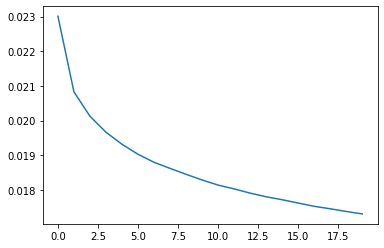

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
# Open a file and use dump()
with open('/content/drive/Shareddrives/AI For Earth/Codes/Models/LSTM/LSTM_first.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model, file)

In [ ]:
del(train)

## Test set development

In [ ]:
# Import data for testing:
test = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/test_scaled_LatLonDateUnscaled.parquet')

print(test.columns)

print(test['date'].max())
print(test['date'].min())
print(len(test))
print(test.info())
print(test.shape)
test.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2020-11-20 00:00:00
2020-01-01 00:00:00
13371200
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13371200 entries, 18329587 to 31700786
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.3 GB
None
(13371200, 12)


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
18329587,0.227062,0.605666,0.979289,0.725619,0.710505,0.715126,0.305186,0.113270,0.091060,62.230810,-162.77490,2020-01-01
18329588,0.219363,0.608976,0.971580,0.746666,0.701298,0.703409,0.334429,0.104657,0.247554,62.081207,-162.77490,2020-01-01
18329589,0.232323,0.594961,0.918358,0.745378,0.709829,0.718960,0.299206,0.105855,0.791739,62.230810,-162.49481,2020-01-01
18329590,0.238541,0.589092,0.946560,0.737288,0.713899,0.722697,0.275514,0.112478,0.244870,62.381150,-162.40146,2020-01-01
18329591,0.234994,0.567396,0.862735,0.745613,0.695790,0.703448,0.363539,0.096604,0.162298,61.932335,-162.21474,2020-01-01


In [ ]:
#Set up all lat/lon pairs that we will be transforming into arrays:

n_input = 60
n_features = 7

pixel_counts = test.groupby(['lat', 'lon']).size() #Counts
pixel_counts = pixel_counts.reset_index()
#Remove lat/lon sets that don't have enough records, as defined by our n_input variable
latlon = pd.lreshape(pixel_counts[pixel_counts[0] > (n_input -1)][['lat', 'lon']], {'lat':['lat'], 'lon':['lon']})

latlon = latlon.drop_duplicates()

#Make sure that we aren't sampling in a pattern:
latlon = latlon.sample(frac = 1, random_state = 1) #Different random state in case latlons are in same order between trian and test. 

print(len(latlon))
latlon.head()

88039


,lat,lon
84720,67.131714,134.39316
72348,63.612114,-156.61307
33409,55.222220,-101.25000
44690,57.756626,-117.30809
41158,56.850266,-94.06120


In [ ]:
#What about using only numpy to pre-process?
# https://stackoverflow.com/questions/66353849/confusions-about-the-input-shape-in-lstm-models

def gen_np(df, n_input):
  num_windows = len(df) - n_input + 1
  # make slices of data
  Xs, ys = [], []

  for w in range(num_windows):
      current_slice = df.iloc[w:w+n_input]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h']].values
      y = current_slice[['density', 'voc']].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

In [ ]:
#Set up an initial X, y to append to
X = np.empty([0, n_input, n_features])
y = np.empty([0,2])

counter = 50000 #From last run, we have 49 save files and saved though counter 50000. 
savept = 50

In [ ]:
#The big data prep:
for i in range(len(latlon) - 50000): #Iterate though our set of viable lat/lons
  counter += 1
  df = test[(test['lat'] == latlon['lat'].iloc[i]) & (test['lon'] == latlon['lon'].iloc[i])] #Make a sub df of each lat/lon pair
  df = df.sort_values(by = 'date') #Make sure we have our values correctly ordered
  X2, y2 = gen_np(df, n_input) #Make your arrays
  X = np.vstack([X, X2]) #Append your arrays
  y = np.concatenate([y, y2])
  #print("Dim: ", X.shape, y.shape)
  if counter%1000 == 0: #For every thousand lat/long pairs (this should run 88 times), acts as check point
    print("Counter: ", counter, ", Shape X: ", X.shape, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    with open(('/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/XY_arrays_60_LSTM_' + str(savept) + '.npy'), 'wb') as f: #Saves two arrays in same file, arrays can be opened seperatly. 
      np.save(f, X)
      np.save(f, y)
    print("Wipeout: ", savept)
    savept += 1
    X = np.empty([0, int(n_input), int(n_features)])
    y = np.empty([0,2])

with open('/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/XY_arrays_60_LSTM_last.npy', 'wb') as f: #final save of X,y to grab the last lat/lon pairs since savept:
      np.save(f, X)
      np.save(f, y)

Counter:  51000 , Shape X:  (28467, 60, 7) 2022-12-20 15:31:09
Wipeout:  50
Counter:  52000 , Shape X:  (27335, 60, 7) 2022-12-20 15:33:11
Wipeout:  51
Counter:  53000 , Shape X:  (28070, 60, 7) 2022-12-20 15:35:16
Wipeout:  52
Counter:  54000 , Shape X:  (29222, 60, 7) 2022-12-20 15:37:22
Wipeout:  53
Counter:  55000 , Shape X:  (28137, 60, 7) 2022-12-20 15:39:26
Wipeout:  54
Counter:  56000 , Shape X:  (29323, 60, 7) 2022-12-20 15:41:31
Wipeout:  55
Counter:  57000 , Shape X:  (28051, 60, 7) 2022-12-20 15:43:38
Wipeout:  56
Counter:  58000 , Shape X:  (28203, 60, 7) 2022-12-20 15:45:41
Wipeout:  57
Counter:  59000 , Shape X:  (28362, 60, 7) 2022-12-20 15:47:47
Wipeout:  58
Counter:  60000 , Shape X:  (30291, 60, 7) 2022-12-20 15:49:56
Wipeout:  59
Counter:  61000 , Shape X:  (29297, 60, 7) 2022-12-20 15:52:00
Wipeout:  60
Counter:  62000 , Shape X:  (28977, 60, 7) 2022-12-20 15:54:10
Wipeout:  61
Counter:  63000 , Shape X:  (28527, 60, 7) 2022-12-20 15:56:14
Wipeout:  62
Counter:  64

In [ ]:
print(counter)

88039


## Data prep - sparse windows, 60, test

The idea being to decrease our number of records while retaining as much informaiton as possible. Instead of succesivly sampling in a rolling window, we will sample X random windows from each latlon, depending on how many records there are avialable. 

In [ ]:
#Peramaeters: 
n_input = 60 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = 7 # how many predictors/Xs/features we have to predict y

In [ ]:
# Import data for testing:
test = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/test_scaled_LatLonDateUnscaled.parquet')

print(test.columns)

print(test['date'].max())
print(test['date'].min())
print(len(test))
print(test.info())
print(test.shape)
test.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2020-11-20 00:00:00
2020-01-01 00:00:00
13371200
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13371200 entries, 18329587 to 31700786
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.3 GB
None
(13371200, 12)


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
18329587,0.227062,0.605666,0.979289,0.725619,0.710505,0.715126,0.305186,0.113270,0.091060,62.230810,-162.77490,2020-01-01
18329588,0.219363,0.608976,0.971580,0.746666,0.701298,0.703409,0.334429,0.104657,0.247554,62.081207,-162.77490,2020-01-01
18329589,0.232323,0.594961,0.918358,0.745378,0.709829,0.718960,0.299206,0.105855,0.791739,62.230810,-162.49481,2020-01-01
18329590,0.238541,0.589092,0.946560,0.737288,0.713899,0.722697,0.275514,0.112478,0.244870,62.381150,-162.40146,2020-01-01
18329591,0.234994,0.567396,0.862735,0.745613,0.695790,0.703448,0.363539,0.096604,0.162298,61.932335,-162.21474,2020-01-01


In [ ]:
#Set up all lat/lon pairs that we will be transforming into arrays:

pixel_counts = test.groupby(['lat', 'lon']).size() #Counts
pixel_counts = pixel_counts.reset_index()
#Remove lat/lon sets that don't have enough records, as defined by our n_input variable
latlon = pd.lreshape(pixel_counts[pixel_counts[0] > (n_input -1)][['lat', 'lon']], {'lat':['lat'], 'lon':['lon']})

latlon = latlon.drop_duplicates()

#Make sure that we aren't sampling in a pattern:
latlon = latlon.sample(frac = 1, random_state = 0)

print(len(latlon))
latlon.head()

88039


,lat,lon
55278,60.058453,122.256226
13338,50.799440,136.353730
68809,62.836746,-146.996890
23591,53.187813,112.546684
11938,50.468132,108.065350


In [ ]:
def rand_gen_np(df, n_input):
  all_windows = list(range(len(df) - n_input + 1)) #List of total number of records in the dataframe minus the n_input window size
  n_samples = int(((len(df) - n_input + 1)/10) + 1) #all windows large enough not to be weeded out get at least one sample
  # make slices of data
  Xs, ys = [], []

  for w in range(n_samples): #For every sample we want to take:
      window = random.choice(all_windows) #Randomly select which window to take
      all_windows.remove(window) #Remove selection from list to prevent resampling
      current_slice = df.iloc[window:window+n_input]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h']].values
      y = current_slice[['density', 'voc']].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

In [ ]:
#Now testing: 
train1 = train[(train['lat'] == 57.106980) & (train['lon'] == -99.56950)]
print(train1.shape)
X, y = rand_gen_np(train1, n_input)
print(X.shape, y.shape)

(119, 12)
(7, 60, 7) (7, 2)


In [ ]:
X = np.empty([0, n_input, n_features])
y = np.empty([0,2])
counter = 38000
savept = 38

In [ ]:
#The data prep - n_input = 60, sparse, test:

#The big data prep:
for i in range(len(latlon) - 38000): #Iterate though our set of viable lat/lons
  counter += 1
  df = test[(test['lat'] == latlon['lat'].iloc[i]) & (test['lon'] == latlon['lon'].iloc[i])] #Make a sub df of each lat/lon pair
  df = df.sort_values(by = 'date') #Make sure we have our values correctly ordered
  X2, y2 = rand_gen_np(df, n_input) #Make your arrays
  X = np.vstack([X, X2]) #Append your arrays
  y = np.concatenate([y, y2])
  #print("Dim: ", X.shape, y.shape)
  if counter%1000 == 0: #For every thousand lat/long pairs (this should run 88 times), acts as check point
    print("Counter: ", counter, ", Shape X: ", X.shape, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    with open(('/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/LSTM_Data_60Sparse_Test/XY_arrays_60Sparse_LSTM_Test_' + str(savept) + '.npy'), 'wb') as f: #Saves two arrays in same file, arrays can be opened seperatly. 
      np.save(f, X)
      np.save(f, y)
    print("Wipeout: ", savept)
    savept += 1
    X = np.empty([0, int(n_input), int(n_features)])
    y = np.empty([0,2])

with open('/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/LSTM_Data_60Sparse_Test/XY_arrays_60Sparse_LSTM_Test_last.npy', 'wb') as f: #final save of X,y to grab the last lat/lon pairs since savept:
      np.save(f, X)
      np.save(f, y)

Counter:  39000 , Shape X:  (3491, 60, 7) 2022-12-20 19:47:18
Wipeout:  38
Counter:  40000 , Shape X:  (3450, 60, 7) 2022-12-20 19:48:38
Wipeout:  39
Counter:  41000 , Shape X:  (3431, 60, 7) 2022-12-20 19:50:00
Wipeout:  40
Counter:  42000 , Shape X:  (3456, 60, 7) 2022-12-20 19:51:20
Wipeout:  41
Counter:  43000 , Shape X:  (3376, 60, 7) 2022-12-20 19:52:43
Wipeout:  42
Counter:  44000 , Shape X:  (3499, 60, 7) 2022-12-20 19:54:03
Wipeout:  43
Counter:  45000 , Shape X:  (3324, 60, 7) 2022-12-20 19:55:23
Wipeout:  44
Counter:  46000 , Shape X:  (3483, 60, 7) 2022-12-20 19:56:46
Wipeout:  45
Counter:  47000 , Shape X:  (3486, 60, 7) 2022-12-20 19:58:06
Wipeout:  46
Counter:  48000 , Shape X:  (3342, 60, 7) 2022-12-20 19:59:29
Wipeout:  47
Counter:  49000 , Shape X:  (3555, 60, 7) 2022-12-20 20:00:49
Wipeout:  48
Counter:  50000 , Shape X:  (3325, 60, 7) 2022-12-20 20:02:11
Wipeout:  49
Counter:  51000 , Shape X:  (3495, 60, 7) 2022-12-20 20:03:31
Wipeout:  50
Counter:  52000 , Shape X

In [ ]:
counter

88039

In [ ]:
del(test)

## Data Prep - Sparse 80, Train

In [ ]:
#Peramaeters: 
n_input = 80 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = 7 # how many predictors/Xs/features we have to predict y

In [ ]:
# Import data for testing:
train = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/train_scaled_LatLonDateUnscaled.parquet')

print(train.columns)

print(train['date'].max())
print(train['date'].min())
print(len(train))
print(train.info())
print(train.shape)
train.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2019-12-31 00:00:00
2019-01-01 00:00:00
18329587
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18329587 entries, 0 to 18329586
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.8 GB
None
(18329587, 12)


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
0,0.166630,0.908916,0.998302,0.779338,0.710750,0.708752,0.305672,0.124832,0.240164,62.684110,-160.44087,2019-01-01
1,0.176869,0.955726,0.995804,0.783470,0.715650,0.708749,0.311526,0.123756,0.228918,62.532246,-160.44087,2019-01-01
2,0.180525,0.959748,0.996218,0.790908,0.722035,0.714708,0.322348,0.123569,0.242246,62.381150,-160.44087,2019-01-01
3,0.183057,0.966050,0.996963,0.790081,0.721543,0.716810,0.302173,0.123513,0.240669,62.230810,-160.44087,2019-01-01
4,0.167732,0.926476,0.995828,0.789999,0.709735,0.705815,0.303099,0.123518,0.239886,62.684110,-160.34750,2019-01-01


In [ ]:
#Set up all lat/lon pairs that we will be transforming into arrays:

pixel_counts = train.groupby(['lat', 'lon']).size() #Counts
pixel_counts = pixel_counts.reset_index()
#Remove lat/lon sets that don't have enough records, as defined by our n_input variable
latlon = pd.lreshape(pixel_counts[pixel_counts[0] > (n_input -1)][['lat', 'lon']], {'lat':['lat'], 'lon':['lon']})

latlon = latlon.drop_duplicates()

#Make sure that we aren't sampling in a pattern:
latlon = latlon.sample(frac = 1, random_state = 0)

print(len(latlon))
latlon.head()

85603


,lat,lon
50478,58.820923,-124.870330
66302,61.932335,120.108925
75123,64.247890,-146.343370
63647,61.343910,118.148340
59666,60.623478,-117.214730


In [ ]:
def rand_gen_np(df, n_input):
  all_windows = list(range(len(df) - n_input + 1)) #List of total number of records in the dataframe minus the n_input window size
  n_samples = int(((len(df) - n_input + 1)/10) + 1) #all windows large enough not to be weeded out get at least one sample
  # make slices of data
  Xs, ys = [], []

  for w in range(n_samples): #For every sample we want to take:
      window = random.choice(all_windows) #Randomly select which window to take
      all_windows.remove(window) #Remove selection from list to prevent resampling
      current_slice = df.iloc[window:window+n_input]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h']].values
      y = current_slice[['density', 'voc']].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

In [ ]:
#Now testing: 
train1 = train[(train['lat'] == 57.106980) & (train['lon'] == -99.56950)]
print(train1.shape)
X, y = rand_gen_np(train1, n_input)
print(X.shape, y.shape)

(119, 12)
(5, 80, 7) (5, 2)


In [ ]:
X = np.empty([0, n_input, n_features])
y = np.empty([0,2])
counter = 27000
savept = 27

In [ ]:
#The data prep - n_input = 80, sparse, train:

#The big data prep:
for i in range(len(latlon) - 27000): #Iterate though our set of viable lat/lons
  counter += 1
  df = train[(train['lat'] == latlon['lat'].iloc[i]) & (train['lon'] == latlon['lon'].iloc[i])] #Make a sub df of each lat/lon pair
  df = df.sort_values(by = 'date') #Make sure we have our values correctly ordered
  X2, y2 = rand_gen_np(df, n_input) #Make your arrays, uses random selection of windows
  X = np.vstack([X, X2]) #Append your arrays
  y = np.concatenate([y, y2])
  #print("Dim: ", X.shape, y.shape)
  if counter%1000 == 0: #For every thousand lat/long pairs (this should run 85 times), acts as check point
    print("Counter: ", counter, ", Shape X: ", X.shape, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    with open(('/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/LSTM_Data_80Sparse_Train/XY_arrays_80Sparse_LSTM_Train_' + str(savept) + '.npy'), 'wb') as f: #Saves two arrays in same file, arrays can be opened seperatly. 
      np.save(f, X)
      np.save(f, y)
    print("Wipeout: ", savept)
    savept += 1
    X = np.empty([0, int(n_input), int(n_features)])
    y = np.empty([0,2])

with open('/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/LSTM_Data_80Sparse_Train/XY_arrays_80Sparse_LSTM_Train_last.npy', 'wb') as f: #final save of X,y to grab the last lat/lon pairs since savept:
      np.save(f, X)
      np.save(f, y)

Counter:  28000 , Shape X:  (3126, 80, 7) 2022-12-20 22:22:30
Wipeout:  27
Counter:  29000 , Shape X:  (3244, 80, 7) 2022-12-20 22:24:20
Wipeout:  28
Counter:  30000 , Shape X:  (3233, 80, 7) 2022-12-20 22:26:11
Wipeout:  29
Counter:  31000 , Shape X:  (3112, 80, 7) 2022-12-20 22:27:58
Wipeout:  30
Counter:  32000 , Shape X:  (3148, 80, 7) 2022-12-20 22:29:45
Wipeout:  31
Counter:  33000 , Shape X:  (3237, 80, 7) 2022-12-20 22:31:34
Wipeout:  32
Counter:  34000 , Shape X:  (3292, 80, 7) 2022-12-20 22:33:23
Wipeout:  33
Counter:  35000 , Shape X:  (3292, 80, 7) 2022-12-20 22:35:10
Wipeout:  34
Counter:  36000 , Shape X:  (3219, 80, 7) 2022-12-20 22:37:00
Wipeout:  35
Counter:  37000 , Shape X:  (3179, 80, 7) 2022-12-20 22:38:49
Wipeout:  36
Counter:  38000 , Shape X:  (3084, 80, 7) 2022-12-20 22:40:38
Wipeout:  37
Counter:  39000 , Shape X:  (3238, 80, 7) 2022-12-20 22:42:25
Wipeout:  38
Counter:  40000 , Shape X:  (3286, 80, 7) 2022-12-20 22:44:15
Wipeout:  39
Counter:  41000 , Shape X

KeyboardInterrupt: ignored

In [ ]:
counter

66434

## Data Prep - Sparse 80 Test

In [ ]:
#Peramaeters: 
n_input = 80 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = 7 # how many predictors/Xs/features we have to predict y

In [ ]:
# Import data for testing:
test = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/test_scaled_LatLonDateUnscaled.parquet')

print(test.columns)

print(test['date'].max())
print(test['date'].min())
print(len(test))
print(test.info())
print(test.shape)
test.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2020-11-20 00:00:00
2020-01-01 00:00:00
13371200
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13371200 entries, 18329587 to 31700786
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.3 GB
None
(13371200, 12)


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
18329587,0.227062,0.605666,0.979289,0.725619,0.710505,0.715126,0.305186,0.113270,0.091060,62.230810,-162.77490,2020-01-01
18329588,0.219363,0.608976,0.971580,0.746666,0.701298,0.703409,0.334429,0.104657,0.247554,62.081207,-162.77490,2020-01-01
18329589,0.232323,0.594961,0.918358,0.745378,0.709829,0.718960,0.299206,0.105855,0.791739,62.230810,-162.49481,2020-01-01
18329590,0.238541,0.589092,0.946560,0.737288,0.713899,0.722697,0.275514,0.112478,0.244870,62.381150,-162.40146,2020-01-01
18329591,0.234994,0.567396,0.862735,0.745613,0.695790,0.703448,0.363539,0.096604,0.162298,61.932335,-162.21474,2020-01-01


In [ ]:
#Set up all lat/lon pairs that we will be transforming into arrays:

latlon = latlon_setup(test, n_input)
latlon.head()

49740


,lat,lon
34023,62.684110,-138.59439
4947,53.539745,111.79979
16537,57.495390,139.24792
46710,66.952736,-152.69191
24511,59.918694,143.44917


In [ ]:
def rand_gen_np(df, n_input):
  all_windows = list(range(len(df) - n_input + 1)) #List of total number of records in the dataframe minus the n_input window size
  n_samples = int(((len(df) - n_input + 1)/10) + 1) #all windows large enough not to be weeded out get at least one sample
  # make slices of data
  Xs, ys = [], []

  for w in range(n_samples): #For every sample we want to take:
      window = random.choice(all_windows) #Randomly select which window to take
      all_windows.remove(window) #Remove selection from list to prevent resampling
      current_slice = df.iloc[window:window+n_input]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h']].values
      y = current_slice[['density', 'voc']].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

In [ ]:
#Now testing: 
train1 = train[(train['lat'] == 57.106980) & (train['lon'] == -99.56950)]
print(train1.shape)
X, y = rand_gen_np(train1, n_input)
print(X.shape, y.shape)

(119, 12)
(5, 80, 7) (5, 2)


In [ ]:
X = np.empty([0, n_input, n_features])
y = np.empty([0,2])
counter = 0
savept = 0

In [ ]:
#The data prep - n_input = 80, sparse, test:

#The big data prep:
for i in range(len(latlon) - 22740): #Iterate though our set of viable lat/lons
  counter += 1
  df = test[(test['lat'] == latlon['lat'].iloc[i]) & (test['lon'] == latlon['lon'].iloc[i])] #Make a sub df of each lat/lon pair
  df = df.sort_values(by = 'date') #Make sure we have our values correctly ordered
  X2, y2 = rand_gen_np(df, n_input) #Make your arrays, uses random selection of windows
  X = np.vstack([X, X2]) #Append your arrays
  y = np.concatenate([y, y2])
  #print("Dim: ", X.shape, y.shape)
  if counter%1000 == 0: #For every thousand lat/long pairs (this should run 85 times), acts as check point
    print("Counter: ", counter, ", Shape X: ", X.shape, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    with open(('/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/LSTM_Data_80Sparse_Test/XY_arrays_80Sparse_LSTM_Test_' + str(savept) + '.npy'), 'wb') as f: #Saves two arrays in same file, arrays can be opened seperatly. 
      np.save(f, X)
      np.save(f, y)
    print("Wipeout: ", savept)
    savept += 1
    X = np.empty([0, int(n_input), int(n_features)])
    y = np.empty([0,2])

with open('/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/LSTM_Data_80Sparse_Test/XY_arrays_80Sparse_LSTM_Test_last.npy', 'wb') as f: #final save of X,y to grab the last lat/lon pairs since savept:
      np.save(f, X)
      np.save(f, y)

Counter:  23000 , Shape X:  (2865, 80, 7) 2022-12-21 01:02:31
Wipeout:  22
Counter:  24000 , Shape X:  (2849, 80, 7) 2022-12-21 01:03:52
Wipeout:  23
Counter:  25000 , Shape X:  (2843, 80, 7) 2022-12-21 01:05:11
Wipeout:  24
Counter:  26000 , Shape X:  (2901, 80, 7) 2022-12-21 01:06:31
Wipeout:  25
Counter:  27000 , Shape X:  (2823, 80, 7) 2022-12-21 01:07:50
Wipeout:  26
Counter:  28000 , Shape X:  (2896, 80, 7) 2022-12-21 01:09:10
Wipeout:  27
Counter:  29000 , Shape X:  (2836, 80, 7) 2022-12-21 01:10:32
Wipeout:  28
Counter:  30000 , Shape X:  (2877, 80, 7) 2022-12-21 01:11:51
Wipeout:  29
Counter:  31000 , Shape X:  (2851, 80, 7) 2022-12-21 01:13:11
Wipeout:  30
Counter:  32000 , Shape X:  (2819, 80, 7) 2022-12-21 01:14:30
Wipeout:  31
Counter:  33000 , Shape X:  (2912, 80, 7) 2022-12-21 01:15:51
Wipeout:  32
Counter:  34000 , Shape X:  (2806, 80, 7) 2022-12-21 01:17:09
Wipeout:  33
Counter:  35000 , Shape X:  (2862, 80, 7) 2022-12-21 01:18:29
Wipeout:  34
Counter:  36000 , Shape X

In [ ]:
counter

22740

## Data Prep - Sparse 30 Train

In [ ]:
train = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/train_scaled_LatLonDateUnscaled.parquet')

n_features = 7
n_input = 30

latlon = latlon_setup(train, n_input)
latlon.head()

Length of df of unique latlon paris that meet cutoff:  215553


,lat,lon
194878,65.229836,120.94917
159813,60.481308,-120.76245
77623,49.272410,107.87863
172516,62.230810,-123.00311
15404,35.723873,90.70021


In [ ]:
X = np.empty([0, n_input, n_features])
y = np.empty([0,2])
counter = 0
savept = 0
path = '/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/LSTM_Data_30Sparse_Train/XY_arrays_30Sparse_LSTM_Train'

data_prep_rand_gen(train, latlon, path, n_input, n_features, X, y, counter, savept)

Starting at:  2022-12-21 02:16:49
Counter:  10000 , Shape X:  (48892, 30, 7) 2022-12-21 02:36:38
Wipeout:  0
Counter:  20000 , Shape X:  (49102, 30, 7) 2022-12-21 02:56:09
Wipeout:  1


KeyboardInterrupt: ignored

## Data Prep - Sparse 30 Test

In [ ]:
test = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/test_scaled_LatLonDateUnscaled.parquet')

n_features = 7
n_input = 30

latlon = latlon_setup(test, n_input)
latlon.head()

Length of df of unique latlon paris that meet cutoff:  215553


,lat,lon
194878,65.229836,120.94917
159813,60.481308,-120.76245
77623,49.272410,107.87863
172516,62.230810,-123.00311
15404,35.723873,90.70021


In [ ]:
X = np.empty([0, n_input, n_features])
y = np.empty([0,2])
counter = 0
savept = 0
path = '/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/LSTM_Data_30Sparse_Test/XY_arrays_30Sparse_LSTM_Test_'

data_prep_rand_gen(train, latlon, path, n_input, n_features, X, y, counter, savept)

Starting at:  2022-12-21 03:07:33
Counter:  10000 , Shape X:  (48892, 30, 7) 2022-12-21 03:26:58
Wipeout:  0
Counter:  20000 , Shape X:  (49102, 30, 7) 2022-12-21 03:46:26
Wipeout:  1
Counter:  30000 , Shape X:  (48974, 30, 7) 2022-12-21 04:06:01
Wipeout:  2
Counter:  40000 , Shape X:  (49356, 30, 7) 2022-12-21 04:25:26
Wipeout:  3
Counter:  50000 , Shape X:  (49228, 30, 7) 2022-12-21 04:44:55
Wipeout:  4
Counter:  60000 , Shape X:  (48560, 30, 7) 2022-12-21 05:04:28
Wipeout:  5
Counter:  70000 , Shape X:  (48654, 30, 7) 2022-12-21 05:23:51
Wipeout:  6
Counter:  80000 , Shape X:  (48670, 30, 7) 2022-12-21 05:43:19
Wipeout:  7
Counter:  90000 , Shape X:  (49140, 30, 7) 2022-12-21 06:02:37
Wipeout:  8
Counter:  100000 , Shape X:  (49625, 30, 7) 2022-12-21 06:22:00
Wipeout:  9
Counter:  110000 , Shape X:  (48327, 30, 7) 2022-12-21 06:41:30
Wipeout:  10
Counter:  120000 , Shape X:  (48650, 30, 7) 2022-12-21 07:00:54
Wipeout:  11
Counter:  130000 , Shape X:  (48753, 30, 7) 2022-12-21 07:20:

## Mapping sparse 30, Nov 1st:

In [3]:
map = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/LSTM_Data/LSTM_Map_Files/LSTM_Map_30_pred.parquet')

map.head()

,lat,lon,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,date,snow density,density_unscaled,VOD_unscaled,density_pred_unscaled,VOD_pred_unscaled
0,33.165960,78.563280,0.077240,0.639721,0.885132,0.000000,0.684257,0.696721,0.207921,0.114647,0.000000,2020-11-01,127.034106,127.034106,0.000000,151.681732,-0.005569
1,50.799440,110.306015,0.143803,0.803512,0.878953,0.702479,0.731068,0.726857,0.256997,0.040906,0.254843,2020-11-01,150.330988,150.330988,0.382231,166.188248,0.493318
2,52.377525,101.530080,0.145976,0.734173,0.992591,0.704958,0.726729,0.720115,0.221864,0.143078,0.197100,2020-11-01,151.091610,151.091610,0.295626,158.279633,0.569852
3,33.250010,80.803940,0.143302,0.689974,0.950213,0.000000,0.667114,0.702663,0.208257,0.074864,0.000000,2020-11-01,150.155632,150.155632,0.000000,152.029907,-0.008379
4,34.605970,87.245850,0.143325,0.707016,0.865505,0.196491,0.650340,0.699951,0.316629,0.042201,0.000000,2020-11-01,150.163865,150.163865,0.000000,153.207581,0.001564


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<__array_function__ internals>:5: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4817: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the 

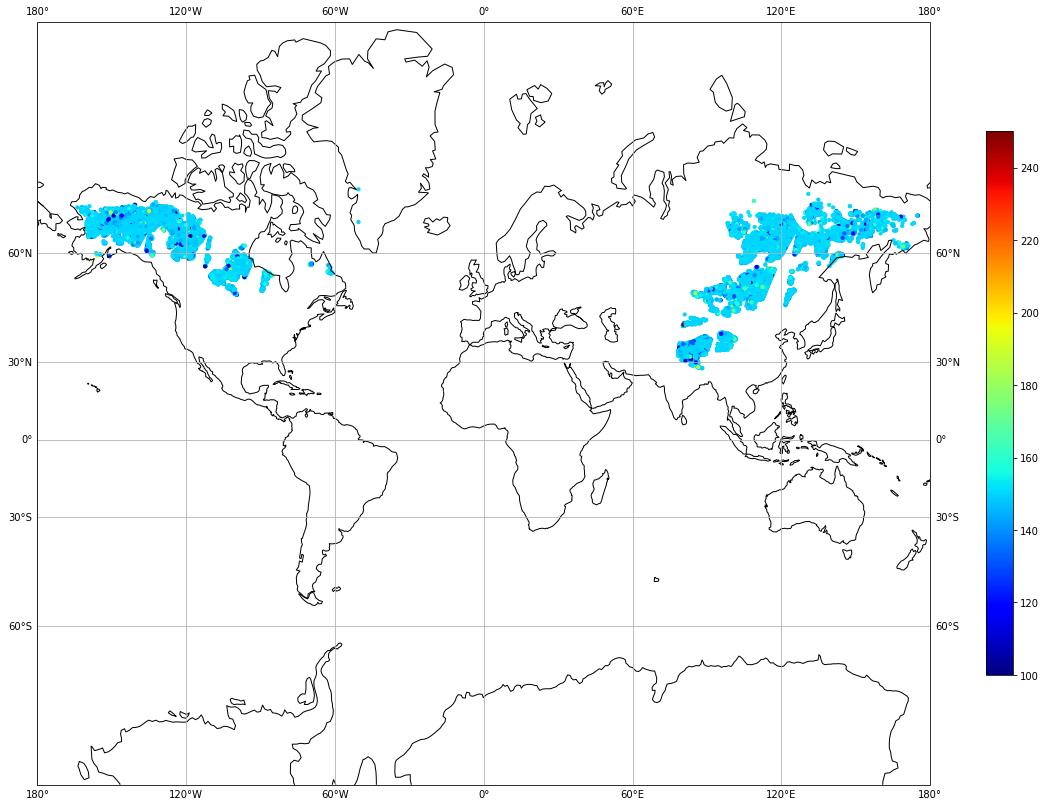

In [4]:
# %% Visualizing The data - y
X_sample = map

fig = plt.figure(figsize=(20, 20))
ax1 = plt.subplot(111, projection=ccrs.Mercator())
#plot1 = plt.contourf(Lon, Lat, Data1, 10, cmap = 'Blues', vmin=100, vmax=450, transform=ccrs.PlateCarree())
plot1 = plt.scatter(X_sample["lon"], X_sample["lat"], c=X_sample['density_unscaled'], vmin=100, vmax=250, cmap='jet', s=10, transform=ccrs.PlateCarree()) #Should be 'Blues'
ax1.set_global()
ax1.coastlines() #Had to rebuild shapely (!pip uninstall shapely, !pip install shapely --no-binary shapely)
ax1.gridlines(draw_labels = True)
#ax1.set_extent([-180, 180, -90, 90])
#ax1.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
cbar = plt.colorbar(plot1, shrink = .5)

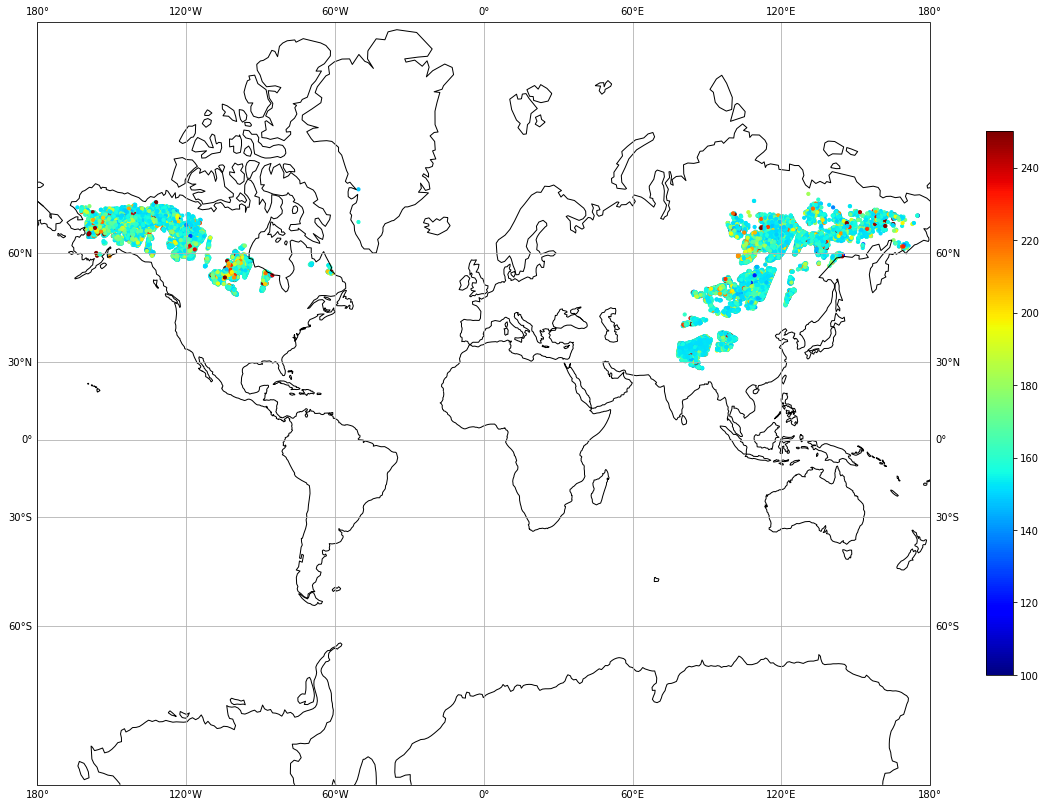

In [5]:
# %% Visualizing The data - y
X_sample = map

fig = plt.figure(figsize=(20, 20))
ax1 = plt.subplot(111, projection=ccrs.Mercator())
#plot1 = plt.contourf(Lon, Lat, Data1, 10, cmap = 'Blues', vmin=100, vmax=450, transform=ccrs.PlateCarree())
plot1 = plt.scatter(X_sample["lon"], X_sample["lat"], c=X_sample['density_pred_unscaled'], vmin=100, vmax=250, cmap='jet', s=10, transform=ccrs.PlateCarree()) #Should be 'Blues'
ax1.set_global()
ax1.coastlines() #Had to rebuild shapely (!pip uninstall shapely, !pip install shapely --no-binary shapely)
ax1.gridlines(draw_labels = True)
#ax1.set_extent([-180, 180, -90, 90])
#ax1.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
cbar = plt.colorbar(plot1, shrink = .5)